# **Dependancies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import *
from keras.callbacks import *
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.layers import *
from sklearn.pipeline import Pipeline

2022-12-04 14:45:43.228668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Loading Data**

In [3]:
selected = pd.read_csv("../Data/train_eth_selected_features.csv")
eth = pd.read_csv("../Data/ethereum_Data.csv")
eth['Date'] = pd.to_datetime(eth['Date'])
eth = eth.set_index("Date")

In [4]:
ethData = eth[selected.columns]
ethData['returns'] = ethData['priceUSD'].pct_change().copy()
Data = ethData.drop(columns=['priceUSD'])
Data = Data[1:]
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = ethData['priceUSD'].shift(-30)[1:] # 反之亦然
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

/tmp/ipykernel_2857409/2726769664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethData['returns'] = ethData['priceUSD'].pct_change().copy()


In [5]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)
tmp_index = Y_test.index

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


In [6]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_val=np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
Y_train=Y_train.values
Y_train=np.reshape(Y_train, (Y_train.shape[0],1,1))
Y_val=Y_val.values
Y_val=np.reshape(Y_val, (Y_val.shape[0],1,1))
Y_test=Y_test.values
Y_test=np.reshape(Y_test, (Y_test.shape[0],1,1))

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [8]:
adam=optimizers.Adam(lr=lr_schedule(0),amsgrad=True)


Learning rate:  0.001


/home/spectre/anaconda3/envs/tensorplustorch/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb

In [9]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])))
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu')))
regressor.add(Dense(1))
regressor.compile(loss="logcosh", optimizer=adam, metrics=['mae'])

2022-12-04 14:45:44.362735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 14:45:44.363964: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1, mode='auto')

In [11]:
regressor.fit(X_train,Y_train, epochs=5000, batch_size=32, validation_data=(X_val,Y_val), callbacks=[earlyStopping])

Epoch 1/5000
46/46 [==============================] - 4s 49ms/step - loss: 203.4476 - mae: 204.1376 - val_loss: 538.3079 - val_mae: 539.0010
Epoch 2/5000
46/46 [==============================] - 2s 40ms/step - loss: 155.5501 - mae: 156.2351 - val_loss: 889.1604 - val_mae: 889.8528
Epoch 3/5000
46/46 [==============================] - 2s 40ms/step - loss: 95.0400 - mae: 95.7220 - val_loss: 1576.6250 - val_mae: 1577.3182
Epoch 4/5000
46/46 [==============================] - 2s 36ms/step - loss: 71.5030 - mae: 72.1829 - val_loss: 1889.3174 - val_mae: 1890.0081
Epoch 5/5000
46/46 [==============================] - 2s 34ms/step - loss: 59.7304 - mae: 60.4062 - val_loss: 1744.4734 - val_mae: 1745.1649
Epoch 6/5000
46/46 [==============================] - 2s 39ms/step - loss: 53.9296 - mae: 54.6026 - val_loss: 1549.2076 - val_mae: 1549.9003
Epoch 7/5000
46/46 [==============================] - 2s 34ms/step - loss: 49.9833 - mae: 50.6574 - val_loss: 1597.1471 - val_mae: 1597.8391
Epoch 8/5000


46/46 [==============================] - 2s 44ms/step - loss: 17.0903 - mae: 17.7263 - val_loss: 432.9390 - val_mae: 433.6301
Epoch 60/5000
46/46 [==============================] - 2s 36ms/step - loss: 17.8452 - mae: 18.4817 - val_loss: 455.0829 - val_mae: 455.7753
Epoch 61/5000
46/46 [==============================] - 2s 37ms/step - loss: 16.7913 - mae: 17.4203 - val_loss: 435.7459 - val_mae: 436.4371
Epoch 62/5000
46/46 [==============================] - 2s 43ms/step - loss: 16.4046 - mae: 17.0398 - val_loss: 428.2325 - val_mae: 428.9235
Epoch 63/5000
46/46 [==============================] - 2s 40ms/step - loss: 16.3347 - mae: 16.9656 - val_loss: 446.8988 - val_mae: 447.5893
Epoch 64/5000
46/46 [==============================] - 2s 33ms/step - loss: 15.6690 - mae: 16.2958 - val_loss: 426.2600 - val_mae: 426.9509
Epoch 65/5000
46/46 [==============================] - 2s 39ms/step - loss: 16.2940 - mae: 16.9328 - val_loss: 425.4432 - val_mae: 426.1335
Epoch 66/5000
46/46 [=============

46/46 [==============================] - 2s 48ms/step - loss: 11.8745 - mae: 12.4896 - val_loss: 402.1869 - val_mae: 402.8784
Epoch 118/5000
46/46 [==============================] - 2s 40ms/step - loss: 12.5404 - mae: 13.1502 - val_loss: 393.1135 - val_mae: 393.8048
Epoch 119/5000
46/46 [==============================] - 2s 35ms/step - loss: 11.0827 - mae: 11.6943 - val_loss: 439.0661 - val_mae: 439.7562
Epoch 120/5000
46/46 [==============================] - 2s 38ms/step - loss: 11.4096 - mae: 12.0187 - val_loss: 438.2560 - val_mae: 438.9460
Epoch 121/5000
46/46 [==============================] - 2s 39ms/step - loss: 11.1077 - mae: 11.7174 - val_loss: 426.9264 - val_mae: 427.6166
Epoch 122/5000
46/46 [==============================] - 2s 47ms/step - loss: 11.6545 - mae: 12.2584 - val_loss: 431.1684 - val_mae: 431.8598
Epoch 123/5000
46/46 [==============================] - 2s 35ms/step - loss: 11.7368 - mae: 12.3437 - val_loss: 416.9879 - val_mae: 417.6803
Epoch 124/5000
46/46 [======

In [12]:
Y_train_pred=regressor.predict(X_train)
y_pred=regressor.predict(X_test)

18/18 [==============================] - 0s 5ms/step


In [13]:
y_pred = y_pred.ravel()
Y_train_pred = Y_train_pred.ravel().reshape(-1)

In [14]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

In [15]:
# for check
r2_score(Y_train, Y_train_pred) #training score

0.9918970661351202

In [16]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:-1.0633244487856714


In [17]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [18]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.7132046821296915


In [19]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:931.4494411682483
rmse:1479.0864336095976
mape:35.2696996638347


-----------------------------

In [20]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = tmp_index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,2149.0,942.516602
2021-06-02,2080.0,879.826538
2021-06-03,2192.0,921.612854
2021-06-04,2305.0,878.976929
2021-06-05,2250.0,819.121948
...,...,...
2022-11-25,NaN,841.403442
2022-11-26,NaN,858.484558
2022-11-27,NaN,873.421448


In [21]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [22]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,2149.0,942.516602,NaN
2021-06-02,2080.0,879.826538,-0.066513
2021-06-03,2192.0,921.612854,0.047494
2021-06-04,2305.0,878.976929,-0.046262
2021-06-05,2250.0,819.121948,-0.068096
...,...,...,...
2022-11-25,NaN,841.403442,-0.181361
2022-11-26,NaN,858.484558,0.020301
2022-11-27,NaN,873.421448,0.017399


<AxesSubplot:>

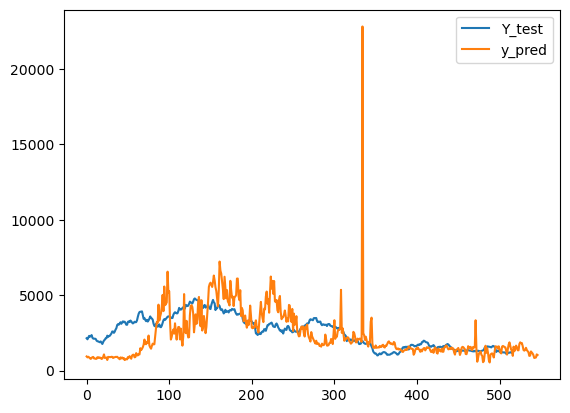

In [23]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [24]:
pre_df.to_csv("../result/LSTM/eth_NN.csv")

In [25]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'